In [1]:
import pandas
import os.path
import collections


Data = collections.namedtuple('Data', ['mnist', 'cifar'])
def load_dataset_files(filename, data_dirs={"cifar": "cifar-data", "mnist": "mnist-data"}, **kwargs):
    dataframes = {
        dataset_name: pandas.read_csv(os.path.join(data_dir, filename), **kwargs)
        for dataset_name, data_dir in data_dirs.items()
    }

    return Data(**dataframes)
        
        

gcp_data = load_dataset_files("baseline-gcp.csv")
cache_data = load_dataset_files("baseline-cache.csv", converters={"Miss Rate": lambda percentage: float(percentage.rstrip('%'))/100})
disk_data = load_dataset_files("baseline-disk.csv")
fetch_size_data = load_dataset_files("fetch-size-results.csv", converters={"Miss Rate": lambda percentage: float(percentage.rstrip('%'))/100})
fetch_size_data = [df[df["Fetch Size"] == 1024] for df in fetch_size_data]
min_queue_size_data = load_dataset_files("min-queue-size.csv")
min_queue_size_data = [df[(df["Minimum Queue Size"] == 1024) & (df["Cache Size"] == 2048)] for df in min_queue_size_data]

In [2]:
import collections

BATCH_SIZE = 512
def get_bucketed_data(data, bucket_field, *fields, average_over_bucket_field=True):
    res = []
    for epoch in data['Epoch'].drop_duplicates():    
        epoch_data = data.loc[(data['Epoch'] == epoch) & (data['Batch Size'] == BATCH_SIZE)][[bucket_field, *fields]]
        if average_over_bucket_field:
            epoch_data = epoch_data.groupby(bucket_field).mean()
        res.append(epoch_data)
        
    return res

In [3]:
from matplotlib import pyplot as plt
import inflect
import numpy
import functools
import math

plt.rcParams.update({'font.size': 14})

BAR_WIDTH = 0.2
# HATCHES = ['', '...']
HATCHES = {'mnist': '', 'cifar': '...'}
COLORS =  {"mnist": 'deeppink', "cifar": 'tab:cyan'}
COLORS2 = {
    'mnist': ['lightskyblue', 'royalblue'],
    'cifar': ['plum', 'magenta']
}
DATASET_DISPLAY_NAMES = {"mnist": "MNIST", "cifar": "CIFAR-10"}

inflect_engine = inflect.engine()

GraphEntry = collections.namedtuple('GraphEntry', ['average', 'error'])


def generate_epoch_name(epoch_index):
    epoch_name = inflect_engine.number_to_words(inflect_engine.ordinal(epoch_index + 1)) + " Epoch"
    epoch_name = epoch_name[0].upper() + epoch_name[1:]
    return epoch_name

def make_bucketed_graph(data, bucket_field, dependent_field, labels_override=None, xlabel_override=None, custom_ordering=None):
    bucketed_data = Data(*[
        get_bucketed_data(item, bucket_field, dependent_field, average_over_bucket_field=False)
        for item in data
    ])
    
    """
    [
        #epoch
        {
            'dataset_name': {size: entry}
        }
    ]
    """
    epoch_entries = []
    plt.figure(figsize=(10,4))
    for dataset_index, (data, dataset_name) in enumerate(zip(bucketed_data, bucketed_data._fields)):
        for epoch, epoch_times in enumerate(data):
            epoch_name = inflect_engine.number_to_words(inflect_engine.ordinal(epoch + 1)) + " Epoch"
            epoch_name = epoch_name[0].upper() + epoch_name[1:]
            bucket_items = collections.defaultdict(list)
            for _, row in epoch_times.iterrows():
                bucket = row[bucket_field]
                dependent_res = row[dependent_field]
                bucket_items[bucket].append(dependent_res)

            bucket_iteration_list = sorted(bucket_items.items(), key=lambda item: item[0])
            if custom_ordering:
                bucket_iteration_list = sorted(zip(custom_ordering, bucket_items.items()), key=lambda item: item[0])
                bucket_iteration_list = [item[1] for item in bucket_iteration_list]
            entries = {
                bucket: GraphEntry(
                    sum(items)/len(items),
                    numpy.std(items)
                )
                for bucket, items in bucket_iteration_list
            }
            if epoch >= len(epoch_entries):
                epoch_entries.append({})
                
            epoch_entries[epoch][dataset_name] = entries
            
    all_num_entries = set()
    for epoch, datasets in enumerate(epoch_entries):
        # This is so gross but we're just ensuring that the same number of items are in all datasets
        num_entries = len(datasets[list(datasets.keys())[0]].keys()) 
        all_num_entries.add(num_entries)
        assert all(num_entries == len(datasets[key].keys()) for key in datasets.keys())
        assert len(all_num_entries) == 1
        
        dataset_keys = {
            dataset_name: list(dataset_entries.keys())
            for dataset_name, dataset_entries in datasets.items()
        }
        epoch_name = generate_epoch_name(epoch)
        for i in range(num_entries):
            entries_at_i = [
                (dataset_name, datasets[dataset_name][dataset_keys[dataset_name][i]])
                for dataset_name, dataset_entries in datasets.items()]
            entries_at_i.sort(key=lambda entry: entry[1].average, reverse=True)
            
            for dataset_name, graph_entry in entries_at_i:
                dataset_index = sorted(dataset_keys.keys(), reverse=True).index(dataset_name)
                bar_shift = BAR_WIDTH * (epoch + dataset_index * 2) - 1.5 * BAR_WIDTH
                
                plt.bar(
                    i + bar_shift,
                    graph_entry.average,
                    BAR_WIDTH,
                    capsize=4,
                    label=f"{epoch_name} {DATASET_DISPLAY_NAMES[dataset_name]}",
                    hatch=HATCHES[dataset_name],
                    color=COLORS2[dataset_name][epoch],
                    edgecolor="white",
                    linewidth=0
                )
                
                error_shift = 0
                plt.errorbar(
                    i - error_shift + bar_shift,
                    graph_entry.average, yerr=graph_entry.error,
                    fmt='none',
                    barsabove=True,
                    color='black',
                    capsize=4
                )
    
    # https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
    handles, labels = plt.gca().get_legend_handles_labels()
    legend_labels = dict(zip(labels, handles))
    legend_labels = {
        "First Epoch (MNIST)": legend_labels["First Epoch MNIST"],
        "Second Epoch (MNIST)": legend_labels["Second Epoch MNIST"],
        "First Epoch (CIFAR-10)": legend_labels["First Epoch CIFAR-10"],
        "Second Epoch (CIFAR-10)": legend_labels["Second Epoch CIFAR-10"],
    }
    plt.legend(legend_labels.values(), legend_labels.keys())
    xlabels = labels_override
    if xlabels is None:
        xlabels = datasets[list(datasets.keys())[0]].keys()
        assert all(xlabels == datasets[key].keys() for key in datasets.keys()), "You may want to use an xlabel override so that we don't have an ambiguity in labelling"
        
    plt.xticks(numpy.arange(all_num_entries.pop()), xlabels)
    plt.title(f"{dependent_field} vs {bucket_field}")
    plt.xlabel(xlabel_override if xlabel_override else bucket_field)
    plt.ylabel(dependent_field)
    plt.grid(axis='y', alpha=0.5) 
    plt.savefig(f"Combined Baseline {dependent_field} vs {bucket_field}", bbox_inches="tight", dpi=300)

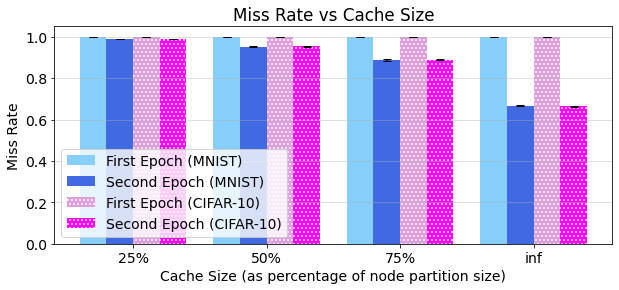

In [4]:
import math

corrected_cache_data = Data(*[data.copy() for data in cache_data])
for data in corrected_cache_data:
    data["Cache Size"] = data["Cache Size"].replace(math.nan, math.inf)
    
make_bucketed_graph(corrected_cache_data, "Cache Size", "Miss Rate", ["25%", "50%", "75%", "inf"], "Cache Size (as percentage of node partition size)")

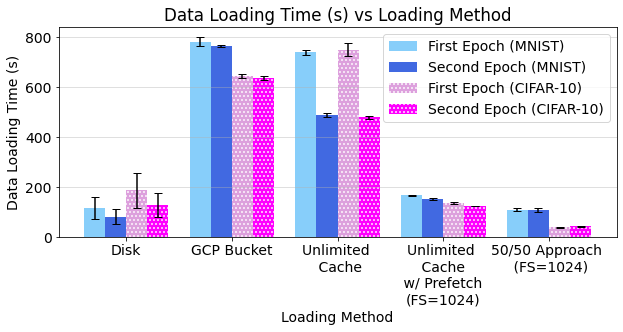

In [8]:
plt.rcParams.update({'font.size': 14})
unlimited_cache_items = Data(
    *[
        data
            .drop(data[~data["Cache Size"].apply(math.isnan)].index)
        for data in cache_data
    ]
)

for data in unlimited_cache_items:
    data["Loading Method"] = "Unlimited \n Cache"

gcp_data_items = []
for data in gcp_data:
    gcp_data_copy = data.copy()
    gcp_data_copy["Loading Method"] = "GCP Bucket"
    gcp_data_items.append(gcp_data_copy)
gcp_data_copy = Data(*gcp_data_items)

disk_data_items = []
for data in disk_data:
    disk_data_copy = data.copy()
    disk_data_copy["Loading Method"] = "Disk"
    disk_data_items.append(disk_data_copy)
disk_data_copy = Data(*disk_data_items)

fetch_size_data_items = []
for data in fetch_size_data:
    fetch_size_data_copy = data.copy()
    fetch_size_data_copy["Loading Method"] = "Unlimited \n Cache \n w/ Prefetch \n(FS=1024)"
    fetch_size_data_items.append(fetch_size_data_copy)
fetch_size_data_copy = Data(*fetch_size_data_items)

min_queue_size_data_items = []
for data in min_queue_size_data:
    min_queue_size_data_copy = data.copy()
    min_queue_size_data_copy["Loading Method"] = "50/50 Approach \n (FS=1024)"
    min_queue_size_data_items.append(min_queue_size_data_copy)
min_queue_size_data_copy = Data(*min_queue_size_data_items)

concated_items = [
    pandas.concat(
        [gcp_data_copy[i], disk_data_copy[i], unlimited_cache_items[i], fetch_size_data_copy[i], min_queue_size_data_copy[i]]
    )
    for i in range(len(gcp_data_copy))
]


make_bucketed_graph(
    concated_items,
    "Loading Method",
    "Data Loading Time (s)",
    custom_ordering=[1, 0, 2, 3, 4]
)

plt.gcf().subplots_adjust(bottom=0.15)
# plt.savefig("./baselines.png", dpi=800)
# plt.savefig("./baselines.png", bbox_inches="tight", dpi=300)